In [1]:
import os
import json
import numpy
import torch
import result
from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_dataset import get_time_data, get_stnn_data
from stnn import SaptioTemporalNN
import matplotlib.pyplot as plt
from matplotlib import axis
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Data

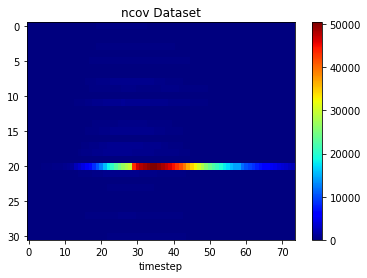

In [3]:
datadir = 'data'
dataset = 'ncov_confirmed'
data = get_time_data(datadir, dataset)

plt.figure('ncov Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [4]:
folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'current'))

In [16]:
stnn = result.Printer(folder)
stnn.get_df(col=['train_loss', 'test_loss', 'true_loss', 'nhid', 'nlayers', 'nz', 'sch_bound', 'rnn_model'], mean=False, min=False).sort_values('test_loss', ascending=True)
# stnn.min_idx()

input-stnn_revised_17-36-01-04-18  x
ori-stnn_01-47-02-04-03  x
ori-stnn_01-47-02-04-04  x
ori-stnn_01-47-02-04-06  x
ori-stnn_01-47-02-04-07  x
ori-stnn_01-47-02-04-08  x
ori-stnn_01-47-02-04-09  x
revised-stnn_01-25-02-04-54  x
revised-stnn_01-25-02-04-55  x
revised-stnn_01-25-02-04-56  x
revised-stnn_01-25-02-04-58  x
revised-stnn_01-25-02-04-59  x
revised-stnn_01-26-02-04-00  x
rnn_04-33-02-04-48  x
rnn_17-11-01-04-04  x
rnn_17-11-01-04-06  x


,train_loss,test_loss,true_loss,nhid,nlayers,nz,sch_bound,rnn_model
ori-stnn_18-48-01-04-19,0.111,0.0446943,234.703,100,2,10,0.001,NaN
ori-stnn_22-04-01-04-12,0.0942005,0.0458592,240.82,100,2,10,0.001,NaN
input-stnn_23-49-01-04-08,0.0113367,0.0505001,265.19,200,4,20,0.001,NaN
ori-stnn_19-02-01-04-40,0.105416,0.0535651,281.285,100,2,10,0.001,NaN
ori-stnn_22-42-01-04-59,0.272756,0.0546985,287.237,100,2,10,0.001,NaN
ori-stnn_18-54-02-04-52,0.110299,0.0644676,338.538,50,4,10,0.001,NaN
input-stnn_17-33-02-04-04,0.00597414,0.0644964,338.689,50,2,20,0.07,NaN
concat-stnn_22-48-01-04-14,0.015762,0.0658371,345.729,200,4,20,0.001,NaN
ori-stnn_19-12-01-04-29,0.0925906,0.0672915,353.366,100,2,10,0.001,NaN
input-stnn_19-13-01-04-18,0.0058806,0.0680278,357.233,100,2,10,0.001,NaN


## Exp 

In [15]:
exps_dir = {}

In [34]:
exp_name = 'input-stnn_19-13-01-04-18'

In [35]:
exp = result.Exp(exp_name, folder)

d:\Jupyter_Documents\ML-code\research_code\output\current
input-stnn_19-13-01-04-18


In [36]:
exps_dir['input_stnn'] = os.path.join(folder, exp_name)
pred = exp.pred().numpy()

config.json
logs.json
model.pt
true_pred_000.txt


In [37]:
pred = pred.T

In [38]:
pred.shape

(31, 24)

([<matplotlib.axis.XTick at 0x1ec90a0ce10>],
 <a list of 1 Text xticklabel objects>)

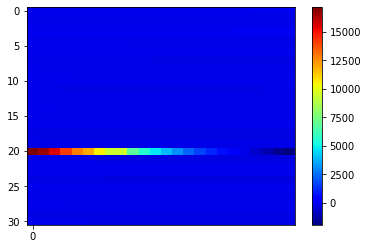

In [39]:
plt.figure()
plt.imshow(test_data-pred, aspect='auto', cmap='jet')
plt.colorbar()
my_x_ticks = numpy.arange(0, 1, 1)
plt.xticks(my_x_ticks)

In [46]:
test_data-pred

array([[-8.06376953e+01, -1.01766052e+02, -1.13320740e+02,
        -1.15636536e+02, -1.17082092e+02, -1.17290527e+02,
        -1.19424744e+02, -1.21528809e+02, -1.19615540e+02,
        -1.18689209e+02, -1.15752441e+02, -1.14806519e+02,
        -1.11852905e+02, -1.08892578e+02, -1.07926453e+02,
        -9.99554443e+01, -9.19801636e+01, -8.00012817e+01,
        -7.10192871e+01, -6.20346069e+01, -4.40476685e+01,
        -2.70587769e+01, -1.30683594e+01,  3.92358398e+00],
       [-1.54865784e+02, -1.70325928e+02, -1.74511414e+02,
        -1.76470276e+02, -1.77754272e+02, -1.78765808e+02,
        -1.79616943e+02, -1.80347473e+02, -1.80976990e+02,
        -1.81519348e+02, -1.83986023e+02, -1.83387024e+02,
        -1.82730896e+02, -1.83025696e+02, -1.83277893e+02,
        -1.83493469e+02, -1.83677734e+02, -1.83835022e+02,
        -1.83969238e+02, -1.84083679e+02, -1.84181274e+02,
        -1.82264404e+02, -1.80335266e+02, -1.80395508e+02],
       [-9.49728394e+01, -1.03844849e+02, -1.08118225e

In [29]:
test_data = data[50:].squeeze().numpy().T
test_data.shape

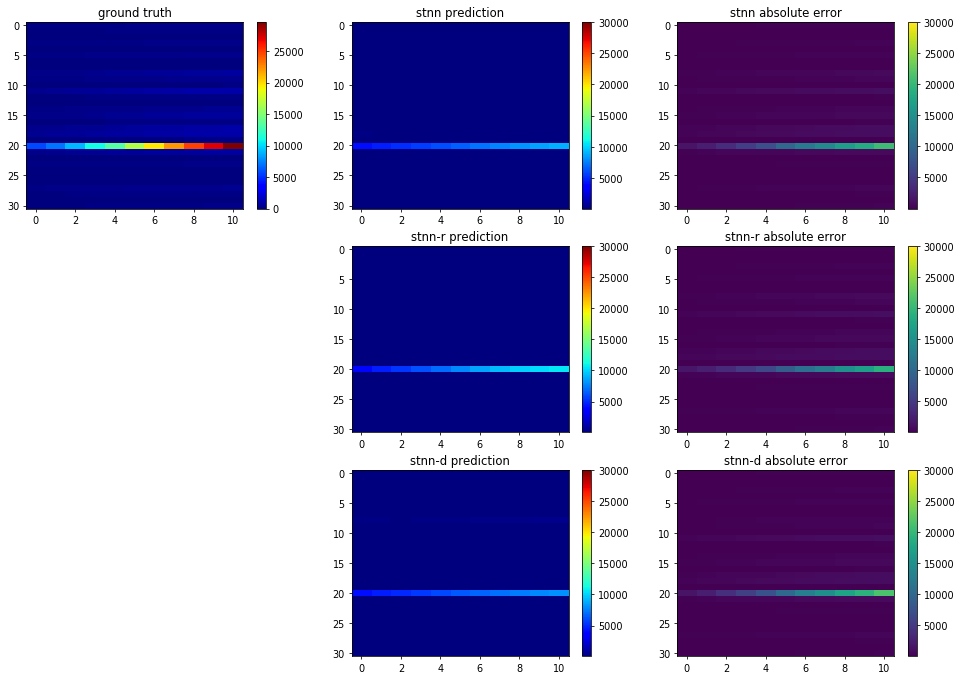

In [99]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(pred_all):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(pred_all[exp], aspect='auto', cmap='jet', vmax=30000)
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(np.abs(test_data - pred_all[exp]), aspect='auto', vmax=30000)
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))

In [13]:
for name, params in exp.model().named_parameters():
    print(name, params)

factors Parameter containing:
tensor([[[ 0.0099],
         [ 0.0249],
         [ 0.0392],
         ...,
         [ 0.0437],
         [-0.0005],
         [ 0.0444]],

        [[ 0.0772],
         [ 0.1556],
         [ 0.1037],
         ...,
         [ 0.1287],
         [ 0.0983],
         [ 0.0770]],

        [[ 0.0647],
         [ 0.1048],
         [ 0.1077],
         ...,
         [ 0.1034],
         [ 0.1033],
         [ 0.0688]],

        ...,

        [[ 0.0883],
         [ 0.0926],
         [ 0.1002],
         ...,
         [ 0.0303],
         [ 0.1118],
         [ 0.0669]],

        [[ 0.0490],
         [ 0.0659],
         [ 0.0504],
         ...,
         [ 0.0868],
         [ 0.0484],
         [ 0.0831]],

        [[ 0.1118],
         [ 0.0729],
         [ 0.0642],
         ...,
         [-0.0198],
         [ 0.0960],
         [ 0.0166]]], requires_grad=True)
dynamic.module.weight Parameter containing:
tensor([[-0.9505, -0.0173]], requires_grad=True)
dynamic.module.bias Paramet

In [ ]:
exp

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


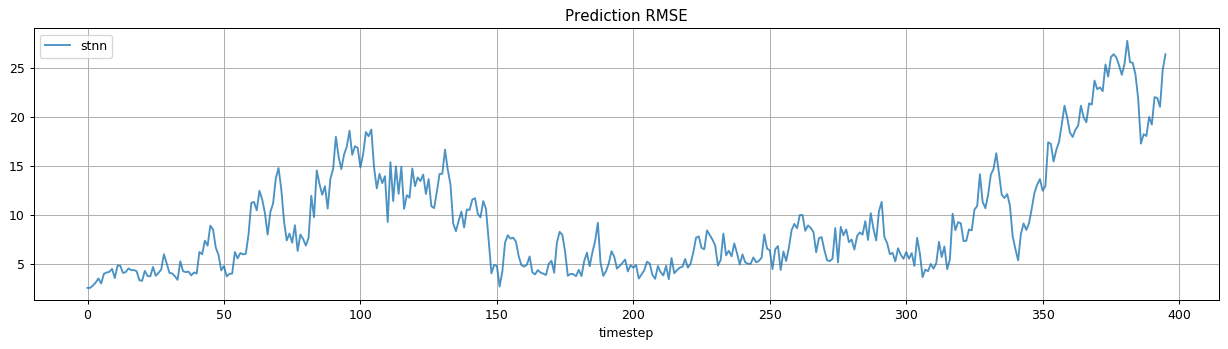

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

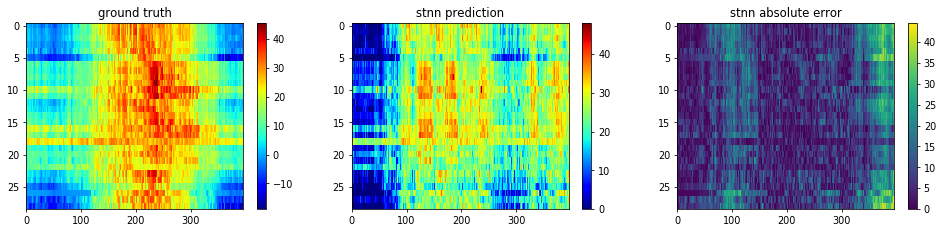

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))